# Importing Packages


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Raw Datasets

- Since the 3 datasets from MovieLens have no column headers, we use the README file as reference and create new column headers.

- After processing all individual files, concatenate all DataFrames in the list into a single DataFrame.

- Save this combined DataFrame as a new CSV file.

In [ ]:
import pandas as pd
import numpy as np
import os
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from geopy.geocoders import Nominatim
from collections import Counter

# Define the column names for the ratings, users, and movies files
ratings_columns = ['reviewer_id', 'movie_id', 'reviewer_rating', 'review_timestamp']
users_columns = ['reviewer_id', 'reviewer_gender', 'reviewer_age', 'reviewer_occupation', 'reviewer_zipcode']
movie_columns = ['movie_id', 'movie_title', 'movie_genre']

# Load the ratings, users, and movies data with the proper encoding
ratings = pd.read_csv('/content/drive/My Drive/raw_datasets/ratings.dat', sep='::', names=ratings_columns, engine='python', encoding='ISO-8859-1')
users = pd.read_csv('/content/drive/My Drive/raw_datasets/users.dat', sep='::', names=users_columns, engine='python', encoding='ISO-8859-1')
movies = pd.read_csv('/content/drive/My Drive/raw_datasets/movies.dat', sep='::', names=movie_columns, engine='python', encoding='ISO-8859-1')

# Merge the dataframes: First movies with ratings, then users
movie_reviews_with_demographic = pd.merge(ratings, movies, on='movie_id')
movie_reviews_with_demographic = pd.merge(movie_reviews_with_demographic, users, on='reviewer_id')

In [ ]:
movie_reviews_with_demographic.head()

,reviewer_id,movie_id,reviewer_rating,review_timestamp,movie_title,movie_genre,reviewer_gender,reviewer_age,reviewer_occupation,reviewer_zipcode
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


# Feature Engineering


 ## Create new features using data from existing columns
  *   Create new feature, movie_year_of_release, by extracting data from the movie_title feature
  *   Create reviewer_area by categorising reviewer_zipcode by the first digit of the zipcode

In [ ]:
# Extract the year from movie_title and create a new column 'movie_year_of_release'
movie_reviews_with_demographic['movie_year_of_release'] = movie_reviews_with_demographic['movie_title'].str.extract(r'\((\d{4})\)')

# Define a function to extract the first digit of each zipcode and assign it as the 'reviewer_area'
def extract_reviewer_area(zipcode_list):
    # Get the first digit of the first zipcode in the list
    return int(str(zipcode_list[0])[0])

# Apply the function to the 'reviewer_zipcode' column
movie_reviews_with_demographic['reviewer_area'] = movie_reviews_with_demographic['reviewer_zipcode'].apply(extract_reviewer_area)


 ## Adjust data format of features

  *   Convert reviewer_age into a new  set of categorical values to avoid confusion on the values
  *   Convert movie_genre from a string into a list of string genres


In [ ]:
# Convert the 'movie_title' column to lowercase
movie_reviews_with_demographic['movie_title'] = movie_reviews_with_demographic['movie_title'].str.lower()

# Define a new encoding for the age ranges
age_encoding = {
    1: 1,   # "Under 18"
    18: 2,  # "18-24"
    25: 3,  # "25-34"
    35: 4,  # "35-44"
    45: 5,  # "45-49"
    50: 6,  # "50-55"
    56: 7   # "56+"
}

# Apply the encoding to the reviewer_age column
movie_reviews_with_demographic['reviewer_age'] = movie_reviews_with_demographic['reviewer_age'].map(age_encoding)

# Split the genre column into lists of genres
movie_reviews_with_demographic['movie_genre'] = movie_reviews_with_demographic['movie_genre'].str.split('|')

## Remove features/columns that are not useful
  *   Drop the reviewer_zipcode column
  *   Drop the review_timestamp column

In [ ]:
# Drop the 'reviewer_zipcode' column
movie_reviews_with_demographic = movie_reviews_with_demographic.drop('reviewer_zipcode', axis=1)

# Drop the 'review_timestamp' column
movie_reviews_with_demographic = movie_reviews_with_demographic.drop('review_timestamp', axis=1)



## Remove duplicate entries

In [ ]:
# Convert 'movie_genre' lists to strings for duplicate checking
movie_reviews_with_demographic['movie_genre'] = movie_reviews_with_demographic['movie_genre'].apply(lambda x: str(x))

# Remove duplicates
movie_reviews_with_demographic = movie_reviews_with_demographic.drop_duplicates()

# Reset the 'movie_genre' column back to lists of integers after dropping duplicates
movie_reviews_with_demographic['movie_genre'] = movie_reviews_with_demographic['movie_genre'].apply(eval)

In [ ]:
movie_reviews_with_demographic.head()

,reviewer_id,movie_id,reviewer_rating,movie_title,movie_genre,reviewer_gender,reviewer_age,reviewer_occupation,movie_year_of_release,reviewer_area
0,1,1193,5,one flew over the cuckoo's nest (1975),[Drama],F,1,10,1975,4
1,1,661,3,james and the giant peach (1996),"[Animation, Children's, Musical]",F,1,10,1996,4
2,1,914,3,my fair lady (1964),"[Musical, Romance]",F,1,10,1964,4
3,1,3408,4,erin brockovich (2000),[Drama],F,1,10,2000,4
4,1,2355,5,"bug's life, a (1998)","[Animation, Children's, Comedy]",F,1,10,1998,4


## Reorder the columns

In [ ]:
# Reorder the columns
desired_order = ['reviewer_id','reviewer_gender','reviewer_age','reviewer_occupation','reviewer_area','reviewer_rating','movie_id','movie_title','movie_genre','movie_year_of_release']
movie_reviews_with_demographic = movie_reviews_with_demographic[desired_order]

In [ ]:
movie_reviews_with_demographic.head()

,reviewer_id,reviewer_gender,reviewer_age,reviewer_occupation,reviewer_area,reviewer_rating,movie_id,movie_title,movie_genre,movie_year_of_release
0,1,F,1,10,4,5,1193,one flew over the cuckoo's nest (1975),[Drama],1975
1,1,F,1,10,4,3,661,james and the giant peach (1996),"[Animation, Children's, Musical]",1996
2,1,F,1,10,4,3,914,my fair lady (1964),"[Musical, Romance]",1964
3,1,F,1,10,4,4,3408,erin brockovich (2000),[Drama],2000
4,1,F,1,10,4,5,2355,"bug's life, a (1998)","[Animation, Children's, Comedy]",1998


# Summary Statistics

In [ ]:
print("Count of datapoints: ", movie_reviews_with_demographic.shape)
print("Count of Unique Reviewers: ", movie_reviews_with_demographic['reviewer_id'].nunique())
print("Count of Unique Movies: ", movie_reviews_with_demographic['movie_title'].nunique())

Count of datapoints:  (1000209, 10)
Count of Unique Reviewers:  6040
Count of Unique Movies:  3706


In [ ]:
movie_reviews_with_demographic.describe().round(2)

,reviewer_id,reviewer_age,reviewer_occupation,reviewer_area,reviewer_rating,movie_id
count,1000209.00,1000209.00,1000209.00,1000209.00,1000209.00,1000209.00
mean,3024.51,3.50,8.04,4.99,3.58,1865.54
std,1728.41,1.36,6.53,3.19,1.12,1096.04
min,1.00,1.00,0.00,0.00,1.00,1.00
25%,1506.00,3.00,2.00,2.00,3.00,1030.00
50%,3070.00,3.00,7.00,5.00,4.00,1835.00
75%,4476.00,4.00,14.00,9.00,4.00,2770.00
max,6040.00,7.00,20.00,9.00,5.00,3952.00


# Data Exploration

## Histogram of Number of Ratings given by each Reviewer

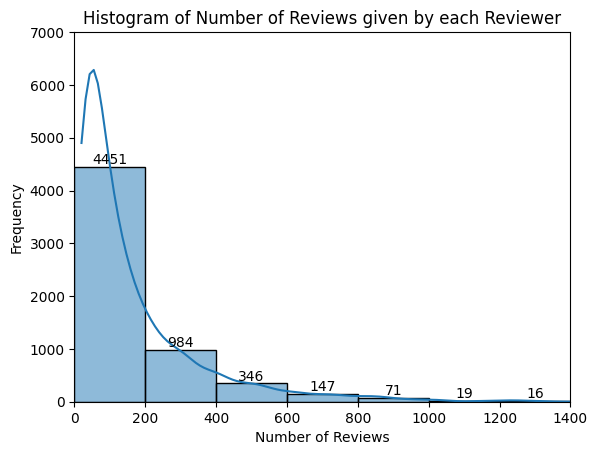

In [ ]:
unique_reviewers = movie_reviews_with_demographic.groupby('reviewer_id').size().reset_index(name='Count_of_Reviews')

bin_interval = 200
bin_edges = np.arange(0, unique_reviewers['Count_of_Reviews'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=unique_reviewers, x='Count_of_Reviews', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'),
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')

plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Reviews given by each Reviewer')
plt.xlim(0, 1400)
plt.ylim(0, 7000)
plt.show()



## Histogram of Number of Ratings given by each Reviewer

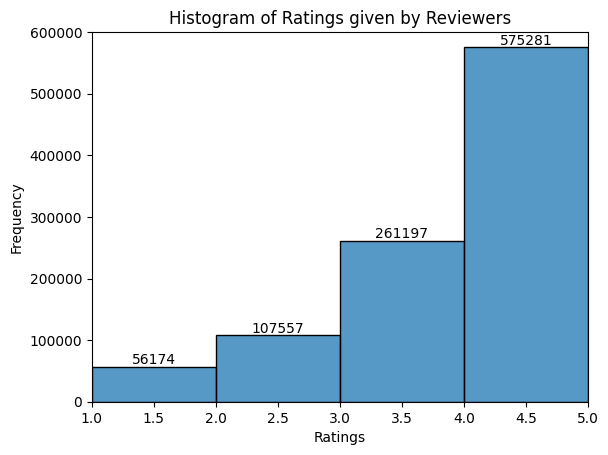

In [ ]:
bin_interval = 1
bin_edges = np.arange(0, movie_reviews_with_demographic['reviewer_rating'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=movie_reviews_with_demographic, x='reviewer_rating', bins=bin_edges, kde=False, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'),
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')

plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings given by Reviewers')
plt.xlim(1, 5)
plt.ylim(0, 600000)
plt.show()

### Create Final Preprocessed Dataset

In [ ]:
# Define the file path and name for the output CSV
output_path = '/content/drive/My Drive/BT4222_Group_5_Submission/processed_datasets/reviewer_demographic_clean.csv'

# Write the merged data to a CSV file
movie_reviews_with_demographic.to_csv(output_path, index=False, encoding='ISO-8859-1')